# Communication (single-cell)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earmingol/scCellFie/blob/main/docs/source/notebooks/sc_communication.ipynb)

In this tutorial, we will walk you through how to infer metabolite-mediated cell-cell communication using single-cell data.

Here, we will use the results we previously generated for the Human Endometrial Cell Atlas (HECA) dataset [(Mareckova & Garcia-Alonso et al 2023)](https://doi.org/10.1038/s41588-024-01873-w) by running our [Quick Start Tutorial](https://sccellfie.readthedocs.io/en/latest/notebooks/quick_start_human.html).

## This tutorial includes following steps:
* [Loading libraries](#loading-libraries)
* [Loading endometrium results](#loading-endometrium-results)
* [Defining cell types](#defining-cell-types)
* [Data preparation](#data-preparation)
* [Inferring intercellular communication](#inferring-intercellular-communication)
* [Visualizing interactions](#visualizing-interactions)

## Loading libraries  <a class="anchor" id="loading-libraries"></a>

In [1]:
import sccellfie
import scanpy as sc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

import textwrap

## To avoid warnings
import warnings
warnings.filterwarnings("ignore")

In addition, we set up a folder to save our figures. This folder is stored in the settings of Scanpy:

In [2]:
sc.settings.figdir = './results/communication-figures/'

## Loading endometrium results <a class="anchor" id="loading-endometrium-results"></a>

We start opening the results previously generated by running the scCellFie pipeline on the HECA dataset. If you haven't run the pipeline yet, please follow [this tutorial](https://sccellfie.readthedocs.io/en/latest/notebooks/quick_start_human.html).

In this case, we will load the objects that were present in ``results['adata']`` in that tutorial. This object contains:
- ``results['adata']``: contains gene expression in ``.X``.
- ``results['adata'].layers['gene_scores']``: contains gene scores as in the original CellFie paper.
- ``results['adata'].uns['Rxn-Max-Genes']``: contains determinant genes for each reaction per cell.
- ``results['adata'].reactions``: contains reaction scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.
- ``results['adata'].metabolic_tasks``: contains metabolic task scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.

Here, we will name this object directly as ``adata``. Each of the previous elements should be under ``adata.``, as for example ``adata.metabolic_tasks``.

In [3]:
adata = sccellfie.io.load_adata(folder='./results/',
                                filename='Human_HECA_scCellFie'
                               )

./results//Human_HECA_scCellFie.h5ad was correctly loaded
./results//Human_HECA_scCellFie_reactions.h5ad was correctly loaded
./results//Human_HECA_scCellFie_metabolic_tasks.h5ad was correctly loaded


In this case, we are interested in the metabolic task scores, which can be found in the adata.metabolic_tasks AnnData object.

In [4]:
adata.metabolic_tasks

AnnData object with n_obs × n_vars = 90001 × 215
    obs: 'n_genes', 'sample', 'percent_mito', 'n_counts', 'Endometriosis_stage', 'Endometriosis', 'Hormonal treatment', 'Binary Stage', 'Stage', 'phase', 'dataset', 'Age', 'lineage', 'celltype', 'label_long'
    uns: 'Binary Stage_colors', 'Biopsy_type_colors', 'Endometrial_pathology_colors', 'Endometriosis_stage_colors', 'GarciaAlonso_celltype_colors', 'Group_colors', 'Hormonal treatment_colors', 'Library_genotype_colors', 'Mareckova_celltype_colors', 'Mareckova_epi_celltype_colors', 'Mareckova_lineage_colors', 'Processing_colors', 'Symbol_colors', 'Tan_cellsubtypes_colors', 'Tan_celltype_colors', 'Treatment_colors', 'celltype_colors', 'dataset_colors', 'genotype_colors', 'hvg', 'label_long_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'lineage_colors', 'neighbors', 'normalization', 'phase_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

## Defining cell types <a class="anchor" id="defining-cell-types"></a>

For metabolic marker identification, we need to specify which column in the AnnData object contains the cell type information:

In [5]:
# Our column indicating the cell types in the adata.obs dataframe
cell_group = 'celltype'

Which can be visualized as

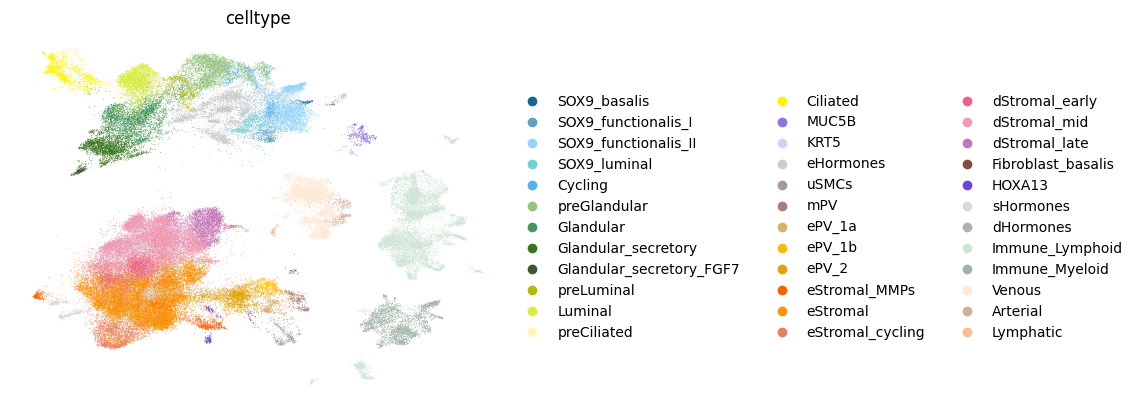

In [6]:
sc.pl.umap(adata, color=cell_group, frameon=False)

## Data preparation <a class="anchor" id="data-preparation"></a>

scCellFie generates separate AnnData objects containing either reaction scores (`adata.reactions`) or task scores (`adata.metabolic_tasks`). Therefore, to infer cell-cell communication, we need to put metabolic task scores together with gene expression in the same AnnData object.

We load our subset of the HECA data, where gene expression of all genes is contained:

In [7]:
bdata = sc.read(filename='./data/HECA-Subset.h5ad',
                backup_url='https://zenodo.org/records/15072628/files/HECA-Subset.h5ad')

Then, we transform gene expression into log1p(CP10k) values.

In [8]:
sc.pp.normalize_total(bdata, target_sum=10000)
sc.pp.log1p(bdata)

We assign a 'type' column for the features in each AnnData, so we can easily recognize which are genes and tasks.

In [9]:
adata.metabolic_tasks.var['type'] = 'metabolic score'
bdata.var['type'] = 'gene expression'

Here, we transfer metabolic scores into the AnnData object containing gene expression. For this, we use a built-in function in scCellFie to transfer features from one source adata into another target adata. In this case we transfer all metabolic tasks (by using `var_names=adata.metabolic_tasks.var_names`).

In [10]:
adata_updated = sccellfie.preprocessing.adata_utils.transfer_variables(
    adata_target=bdata,
    adata_source=adata.metabolic_tasks,
    var_names=adata.metabolic_tasks.var_names
)

In [11]:
adata_updated

AnnData object with n_obs × n_vars = 90001 × 17951
    obs: 'n_genes', 'sample', 'percent_mito', 'n_counts', 'Endometriosis_stage', 'Endometriosis', 'Hormonal treatment', 'Binary Stage', 'Stage', 'phase', 'dataset', 'Age', 'lineage', 'celltype', 'label_long'
    var: 'type'
    uns: 'Binary Stage_colors', 'Biopsy_type_colors', 'Endometrial_pathology_colors', 'Endometriosis_stage_colors', 'GarciaAlonso_celltype_colors', 'Group_colors', 'Hormonal treatment_colors', 'Library_genotype_colors', 'Mareckova_celltype_colors', 'Mareckova_epi_celltype_colors', 'Mareckova_lineage_colors', 'Processing_colors', 'Symbol_colors', 'Tan_cellsubtypes_colors', 'Tan_celltype_colors', 'Treatment_colors', 'celltype_colors', 'dataset_colors', 'genotype_colors', 'hvg', 'label_long_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'lineage_colors', 'neighbors', 'phase_colors', 'umap', 'log1p'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

## Inferring intercellular communication <a class="anchor" id="inferring-intercellular-communication"></a>

Using our new AnnData object (``adata_updated``), we can infer cell-cell communication by computing communication scores (see [this review paper for more details](https://www.nature.com/articles/s41576-020-00292-x)) for a list of ligand-receptor (LR) pairs.

### Defining list of LR pairs

In this case, our ligand is represented by the metabolic task(s) that produce this metabolite, while the receptor is the gene encoding for the known protein that interacts with the ligand.

Here we define a few LR pairs:

In [12]:
lr_pairs = [('Synthesis of estradiol-17beta (E2) from androstenedione', 'ESR1'),
            ('Synthesis of L-kynurenine from tryptophan', 'AHR'),
            ('Synthesis of thromboxane from arachidonate', 'TBXA2R'),
           ]

If you are interested in other interactions, you can always define your own LR pairs based on the metabolic tasks present in scCellFie's metabolic database.

### Computing communication scores

In this case we use the geometric mean between the cell-type level aggregated values (using the Tuckey's trimean). For the ligand we use the metabolic score of the corresponding metabolic task, while for the receptor we use the log-transformed gene expression (log1p(CP10k)).

In [14]:
ccc_df = sccellfie.communication.compute_communication_scores(adata_updated,
    var_pairs=lr_pairs,
    groupby=cell_group,
    communication_score='gmean',
    agg_func='trimean',
    ligand_threshold=np.log(2), # Greater than this metabolic activity for considering it active
    receptor_threshold=0., # Greater than this expression for considering it active
)

Our communication scores are in the `'score'` columm of the ``ccc_df``. Additionlly, this dataframe contains the fraction of cells expressing the ligand, and the receptor. These fractions were calculated as the cells with the metabolic score greater than the ``ligand_threshold`` with respect the total of cells in a cell type. Similarly, the fraction was calculated for the receptor, based on the ``receptor_threshold`` value.

In [15]:
ccc_df.head()

,sender_celltype,receiver_celltype,ligand,receptor,score,ligand_fraction,receptor_fraction
0,Arterial,Arterial,Synthesis of estradiol-17beta (E2) from andros...,ESR1,0.000000,0.082136,0.057495
1,Arterial,Arterial,Synthesis of L-kynurenine from tryptophan,AHR,0.201260,0.088296,0.605749
2,Arterial,Arterial,Synthesis of thromboxane from arachidonate,TBXA2R,0.000000,0.110883,0.188912
3,Arterial,Ciliated,Synthesis of estradiol-17beta (E2) from andros...,ESR1,0.447837,0.082136,0.712575
4,Arterial,Ciliated,Synthesis of L-kynurenine from tryptophan,AHR,0.090771,0.088296,0.459747


### Other cell-cell communication tools

As you can see, here we do not compute P-values since we do not perform any statistical analysis (e.g. permutation analysis).

Other tools already implement this kind of analysis  (e.g. [CellPhoneDB](https://www.nature.com/articles/s41596-024-01137-1) and [LIANA](https://www.nature.com/articles/s41556-024-01469-w)), so we can export our unified AnnData object to run the analysis with another tool.

We can save this new object:

In [16]:
adata_updated.write_h5ad('./results/CCC-Endometrium.h5ad')

Similarly, we can output our database of LR pairs:

In [17]:
lr_df = pd.DataFrame.from_records(lr_pairs, columns=['ligand', 'receptor'])
lr_df

,ligand,receptor
0,Synthesis of estradiol-17beta (E2) from andros...,ESR1
1,Synthesis of L-kynurenine from tryptophan,AHR
2,Synthesis of thromboxane from arachidonate,TBXA2R


We can additionally define shorter names for our LR pairs:

In [18]:
lr_names = ['E2 - ESR1',
            'Kynurenine - AHR',
            'Thromboxane - TBXA2R']

In [19]:
lr_df['lr_name'] = lr_names
lr_df

,ligand,receptor,lr_name
0,Synthesis of estradiol-17beta (E2) from andros...,ESR1,E2 - ESR1
1,Synthesis of L-kynurenine from tryptophan,AHR,Kynurenine - AHR
2,Synthesis of thromboxane from arachidonate,TBXA2R,Thromboxane - TBXA2R


In [20]:
lr_df.to_csv('./results/LR-Pairs.csv', index=False)

<div class="alert alert-info">
<b>Note!</b>

Please make sure to format this data in the proper way for the tool you plan using.

</div> 

## Visualizing interactions <a class="anchor" id="visualizing-interactions"></a>

In this case we can visualize each of the ligand-receptor interactions we passed.

For clear visualizations, we can filter important interactions based on the ``'score'``, ``'ligand_fraction'`` and ``'receptor_fraction'``. Additionally, we can define a specific list of cell types to include:

In [42]:
celltypes = ['SOX9_luminal', 'preLuminal', 'Luminal',
             'preCiliated', 'Ciliated', 'dHormones',
             'preGlandular', 'Glandular', 'Glandular secretory',
             'dStromal_early', 'dStromal_mid', 'dStromal_late']

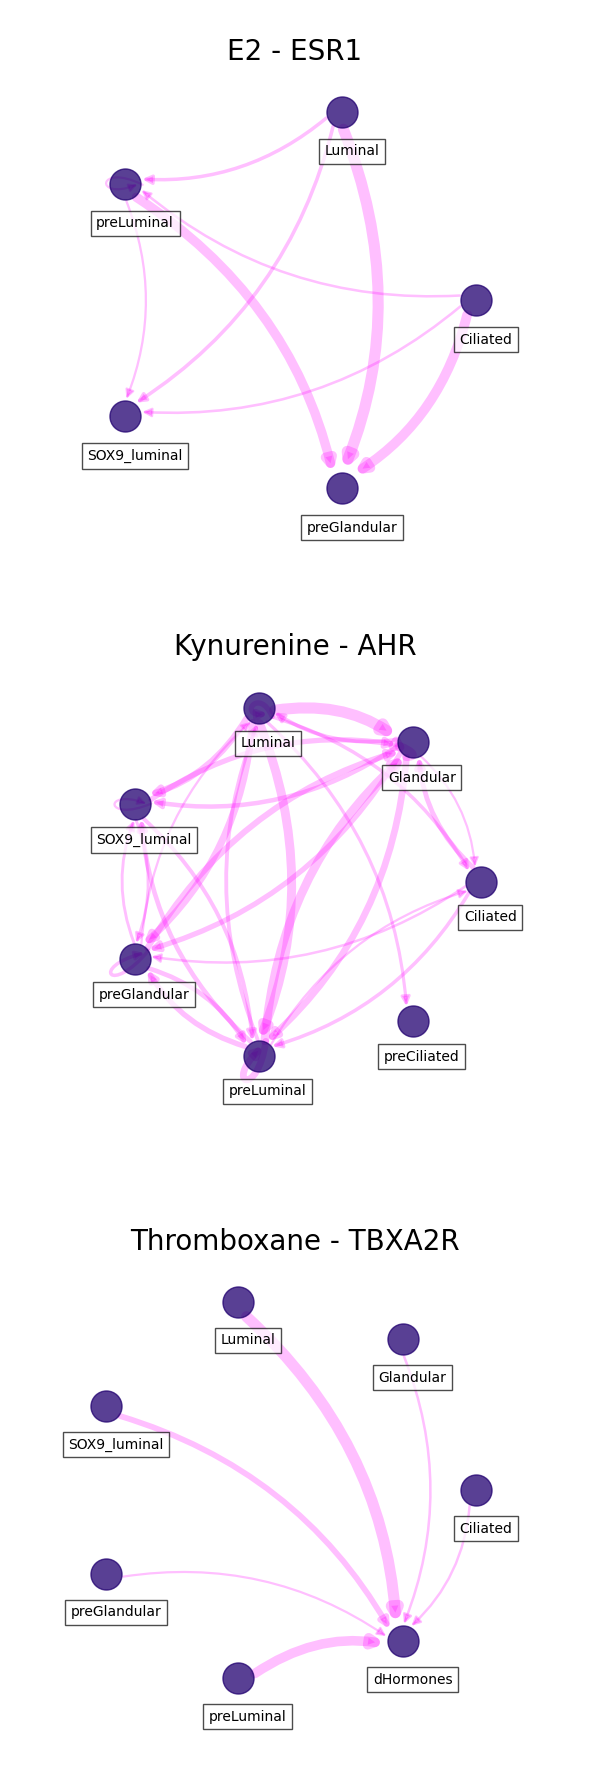

In [43]:
fig, axs = plt.subplots(len(lr_pairs), 
                        1, 
                        figsize = (6, 6 * len(lr_pairs)))

axes = axs.flatten()

for i, lr in enumerate(lr_pairs):
    df = ccc_df.loc[(ccc_df.ligand == lr[0]) & (ccc_df.receptor == lr[1])]
    
    # THRESHOLD FOR IMPORTANT COMMUNICATION SCORE IS MEAN + 1 STD
    score_thresh = df.score.mean() + df.score.std()
    
    # CELL TYPES MUST EXPRESS LIGAND AND RECEPTOR IN MORE THAN 10% OF SINGLE CELLS
    frac_thresh = (df.ligand_fraction > 0.1) & (df.receptor_fraction > 0.1)
    
    # FILTER INTERACTONS
    filtered_df = df.loc[(df.score >= score_thresh) & (frac_thresh)]
    
    # INCLUDE SPECIFIC CELL TYPES
    filtered_df = filtered_df.loc[(filtered_df.sender_celltype.isin(celltypes)) \
                                  & (filtered_df.receiver_celltype.isin(celltypes))]
    
    # PLOT INTERACTIONS
    ax = axes[i]
    sccellfie.plotting.plot_communication_network(filtered_df, 
                                                  'sender_celltype', 
                                                  'receiver_celltype', 
                                                  'score', 
                                                  panel_size=(6,6),
                                                  network_layout='circular',
                                                  edge_color='magenta',
                                                  edge_width=8,
                                                  edge_arrow_size=12,
                                                  edge_alpha=0.25,
                                                  node_color='#210070',
                                                  node_size=500,
                                                  node_alpha=0.75,
                                                  node_label_size=10,
                                                  node_label_alpha=0.7,
                                                  node_label_offset=(0.05, -0.2),
                                                  title=lr_names[i],
                                                  title_fontsize=20,
                                                  tight_layout=True,
                                                  ax=ax
                                                 )